In [ ]:
!pip install langchain-openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.0 MB/s eta 0:00:00


In [ ]:
from langgraph.graph import END, StateGraph
from langchain_openai import ChatOpenAI
from typing import TypedDict



In [ ]:
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

In [ ]:
class ProjectState(TypedDict):
    input: str
    plan: str
    schedule: str
    review: str
    supervisor_decision: str
    next: str

In [ ]:
llm = ChatOpenAI(model="gpt-4-turbo", api_key=api_key)

In [ ]:
def planner_agent(state:ProjectState)-> ProjectState:
    project_info = state["input"]
    prompt = f"""
As a Project Planner, your task is to break down the following project description into major phases and detailed tasks. Be very specific and ensure that the output is a clear and concise Markdown list of the phases and their corresponding tasks.

Project Description:
{project_info}

Provide the output as a Markdown list.
"""
    response = llm.invoke(prompt).content
    print("\nPlanner Agent\n")
    print("\nAgent Output: ",response)
    state["plan"] = response
    print("\nState: \n", state)
    return state

def scheduler_agent(state:ProjectState)-> ProjectState:
    plan = state["plan"]
    project_info = state["input"] # Get project info to extract team members
    prompt = f"""
You are a Project Scheduler. Based on the provided plan and the project description, assign realistic timelines (in weeks) for each task. Assign appropriate team members *only* from the "Team Members" list provided in the project description. Do not create or use any team member names not listed. Assign a project leader *only* from the provided team members, and indicate dependencies where appropriate.

Project Plan:
{plan}

Project Description:
{project_info}



Output as a Markdown table with columns: Task | Duration (weeks) | Team Member | Dependencies
"""
    response = llm.invoke(prompt).content
    print("\nSchedule Agent\n")
    print("\nAgent Output: ",response)

    state["schedule"] = response
    return state

def reviewer_agent(state:ProjectState)-> ProjectState:
    schedule = state["schedule"]
    project_info = state["input"] # Get project info to extract team members
    prompt = f"""
You are a Project Reviewer. Review this schedule for completeness, any missing dependencies or tasks, potential bottlenecks, unrealistic timelines, and issues with team member assignments based on the project description.

Here is the schedule to review:
{schedule}

Project Description:
{project_info}


Output suggestions as a Markdown list. If no issues are found that would prevent successful project completion, write: "No significant issues found."
"""
    response = llm.invoke(prompt).content
    print("\nReviewer Agent\n")
    print("\nAgent Output: ",response)
    state["review"] = response
    return state

In [ ]:
def supervisor_agent(state: ProjectState) -> ProjectState:
    review = state["review"]
    plan = state["plan"]
    schedule = state["schedule"]

    prompt = f"""
You are a Supervisor Agent overseeing a project schedule workflow.

Here is the current plan:
{plan}

Here is the schedule:
{schedule}

Here is the reviewer feedback:
{review}

Based on this, decide:
- If the project can be marked as complete → reply "COMPLETE"
- If it needs more revision → reply "NEEDS REVISION"

Be smart: Minor issues can be accepted. Major missing parts require revision.
"""

    decision = llm.invoke(prompt).content.strip()

    print("\nSupervisor Decision: ", decision)

    if "COMPLETE" in decision.upper():
        state["supervisor_decision"] = "Complete"
    else:
        state["supervisor_decision"] = "Needs revision"

    return state



In [ ]:
# ==========================
# LangGraph Definition
# ==========================

graph = StateGraph(ProjectState)

# Add nodes
graph.add_node("PlannerAgent", planner_agent)
graph.add_node("SchedulerAgent", scheduler_agent)
graph.add_node("ReviewerAgent", reviewer_agent)
# graph.add_node("SupervisorAgent", supervisor_agent)

# Add normal edges
graph.set_entry_point("PlannerAgent")
graph.add_edge("PlannerAgent", "SchedulerAgent")
graph.add_edge("SchedulerAgent", "ReviewerAgent")
# graph.add_edge("ReviewerAgent", "SupervisorAgent")

# # Add conditional edge
# graph.add_conditional_edges(
#     "SupervisorAgent",
#     lambda state: state["supervisor_decision"],
#     {
#         "Complete": END,
#         "Needs revision": "PlannerAgent"
#     }
# )



# Compile the graph
project_graph = graph.compile()

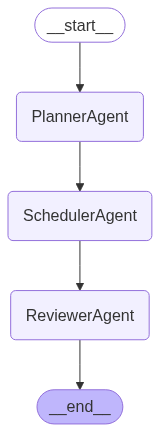

In [ ]:
project_graph

In [ ]:
# ==========================
# Example Run
# ==========================

project_input = f"""
**Project Type:** Website

**Project Objectives:** Create a website for a small business

**Industry:** Technology

**Team Members:**
- John Doe (Project Manager)
- Jane Doe (Software Engineer)
- Bob Smith (Designer)
- Alice Johnson (QA Engineer)
- Tom Brown (QA Engineer)

**Project Requirements:**
- Create a responsive design that works well on desktop and mobile devices
- Implement a modern, visually appealing user interface with a clean look
- Develop a user-friendly navigation system with intuitive menu structure
- Include an "About Us" page highlighting the company's history and values
- Design a "Services" page showcasing the business's offerings with descriptions
- Create a "Contact Us" page with a form and integrated map for communication
- Implement a blog section for sharing industry news and company updates
- Ensure fast loading times and optimize for search engines (SEO)
- Integrate social media links and sharing capabilities
- Include a testimonials section to showcase customer feedback and build trust
"""

# Run the graph
output = project_graph.invoke({"input": project_input})





Planner Agent


Agent Output:  Below is a structured breakdown of the website project into major phases and detailed tasks formatted in Markdown:

### **Phase 1: Planning**
1. **Requirement Gathering**
   - Conduct initial meetings with stakeholders to refine project objectives and requirements.
   - Document and confirm the final requirements specification.
2. **Resource Planning**
   - Assign roles and responsibilities among team members.
   - Prepare schedules and timelines for each phase and task.
3. **Technology Stack Selection**
   - Decide on the frameworks, languages, and tools to be used for development and design.
4. **Project Scope Documentation**
   - Document the project's scope, including deliverables and deadlines.

### **Phase 2: Design**
1. **Initial Drafts and Wireframes**
   - Bob Smith to create initial design drafts and wireframes for desktop and mobile interfaces.
   - Review and feedback session with the team.
2. **UI/UX Design**
   - Development of a modern, vi

In [ ]:
# Show outputs
print("\n# 📌 Project Plan\n")
print(output["plan"])
print("\n# 🗓️ Project Schedule\n")
print(output["schedule"])
print("\n# ✅ Reviewer Feedback\n")
print(output["review"])
# print("\n# 🧑‍💼 Supervisor Decision\n")
# print(output["supervisor_decision"])


# 📌 Project Plan

Below is a structured breakdown of the website project into major phases and detailed tasks formatted in Markdown:

### **Phase 1: Planning**
1. **Requirement Gathering**
   - Conduct initial meetings with stakeholders to refine project objectives and requirements.
   - Document and confirm the final requirements specification.
2. **Resource Planning**
   - Assign roles and responsibilities among team members.
   - Prepare schedules and timelines for each phase and task.
3. **Technology Stack Selection**
   - Decide on the frameworks, languages, and tools to be used for development and design.
4. **Project Scope Documentation**
   - Document the project's scope, including deliverables and deadlines.

### **Phase 2: Design**
1. **Initial Drafts and Wireframes**
   - Bob Smith to create initial design drafts and wireframes for desktop and mobile interfaces.
   - Review and feedback session with the team.
2. **UI/UX Design**
   - Development of a modern, visually appeal

In [ ]:
!pip install gradio

import gradio as gr

# Dummy agent (replace this with your real project_graph agent)
class MockProjectGraph:
    def invoke(self, inputs):
        return {
            "plan": "- Requirement Gathering\n- UI/UX Design\n- Frontend + Backend Development\n- Testing\n- Deployment",
            "schedule": "- Week 1: Planning\n- Week 2–3: Development\n- Week 4: QA & Launch",
            "review": "Good scope and realistic timeline. Ensure SEO optimization is tested before deployment."
        }

project_graph = MockProjectGraph()

# Function to build markdown output
def run_project_workflow(project_type, objectives, industry, team, requirements):
    project_input = f"""
**Project Type:** {project_type}

**Project Objectives:** {objectives}

**Industry:** {industry}

**Team Members:**\n{team}

**Project Requirements:**\n{requirements}
"""
    output = project_graph.invoke({"input": project_input})

    print(output)

    # Create combined Markdown string
    combined_output = (
        f"\n# 📌 Project Plan\n\n{output['plan']}\n\n"
        f"# 🗓️ Project Schedule\n\n{output['schedule']}\n\n"
        f"# ✅ Reviewer Feedback\n\n{output['review']}"
    )
    return combined_output

# Gradio interface
gr.Interface(
    fn=run_project_workflow,
    inputs=[
        gr.Textbox(label="Project Type", value="Website"),
        gr.Textbox(label="Project Objectives", lines=2, placeholder="e.g., Create a website for a small business"),
        gr.Textbox(label="Industry", placeholder="e.g., Technology"),
        gr.Textbox(label="Team Members", lines=5, placeholder="- John Doe (PM)\n- Jane Doe (Engineer)"),
        gr.Textbox(label="Project Requirements", lines=10, placeholder="- Responsive design\n- SEO optimization\n...")
    ],
    outputs=gr.Markdown(label="🧾 Output"),
    title="🧠 Project Workflow Generator",
    description="Fill in your project details to generate a full plan, schedule, and feedback summary."
).launch(inline=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ff5f033b6de18c751.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
